In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [16]:

from google.colab import files
uploaded = files.upload()


Saving Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20241028.csv to Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20241028.csv


In [43]:
# Load the dataset
file_path = "Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20241028.csv"
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime format and set as index
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

# Fill missing values in 'Other' with the median
data['Other'].fillna(data['Other'].median(), inplace=True)

# Aggregate data by day to handle any duplicate dates
data = data.resample('D').sum()

<ipython-input-43-3cdd32351c64>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Other'].fillna(data['Other'].median(), inplace=True)



Insight 1: Overall Passenger Distribution
The total number of passengers for each service type has been visualized. It can be observed that 'Rapid Route' services have the highest total passenger count, indicating it is the most popular service type. Services like 'School' and 'Other' have significantly lower usage. This insight can help in understanding which services need more resources or attention.
Rapid Route     24161455.0
Local Route     18971696.0
Light Rail      13800866.0
School           4512469.0
Peak Service      344437.0
Other              82434.0
dtype: float64


<ipython-input-57-6e841c3e9b06>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_passengers.index, y=total_passengers.values, palette="viridis")


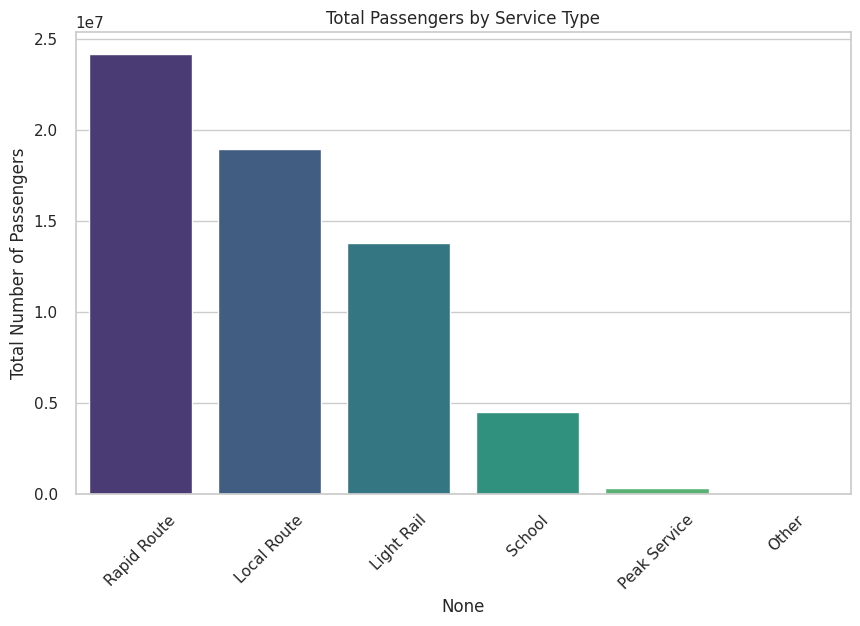


Insight 2: Descriptive Statistics
The table below shows key statistics (mean, min, max) for each service type, giving a clear view of average usage and variability. This can be useful to identify patterns and outliers in daily passenger counts across different services.
                      mean  min      max
Local Route    9891.395203  1.0  21070.0
Light Rail     7195.446298  0.0  15154.0
Peak Service    179.581335  0.0   1029.0
Rapid Route   12597.213243  0.0  28678.0
School         2352.694995  0.0   7255.0
Other            42.979145  0.0   1105.0


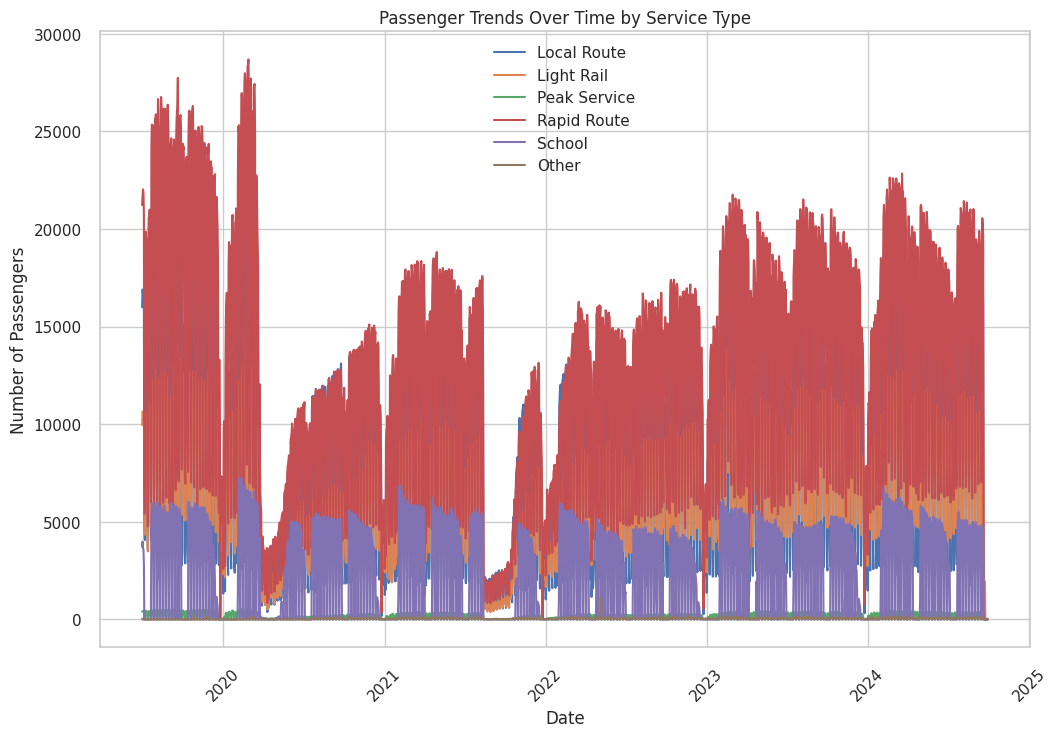


Insight 3: Correlation Between Service Types
The correlation matrix shows relationships between different service types. High correlations could indicate that certain services are used interchangeably or are affected by similar factors. For example, 'Local Route' and 'Peak Service' might have a high correlation, suggesting they serve overlapping commuter needs.


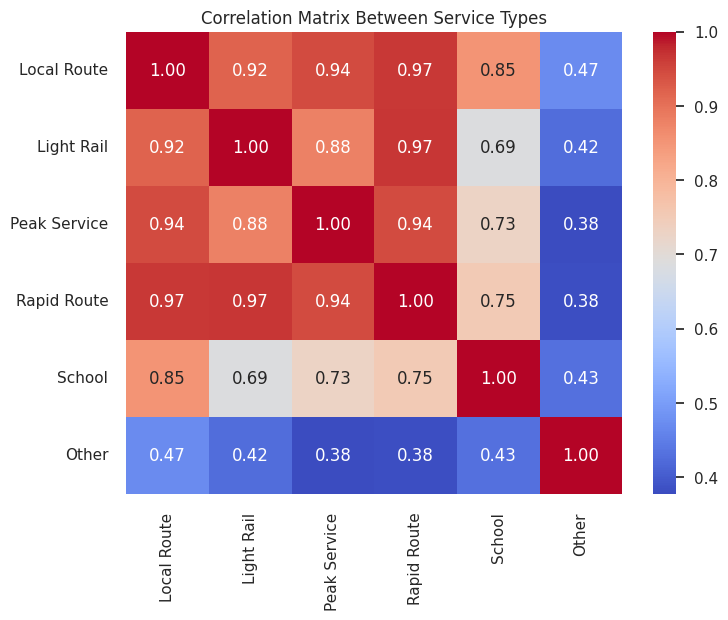


Insight 4: Outlier Detection
Outliers have been identified based on passenger counts exceeding three standard deviations from the mean.
These outliers may indicate unusual events, such as special events or disruptions, that caused significant deviations from normal service usage.
                    mean     max         std
Peak Service  179.581335  1029.0  156.532738
Other          42.979145  1105.0   41.738518


In [57]:
# Function to provide and explain insights
def display_insights(data):

    # 1. Overall Passenger Distribution
    service_columns = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
    total_passengers = data[service_columns].sum().sort_values(ascending=False)
    # Explanation
    print("\nInsight 1: Overall Passenger Distribution")
    print("The total number of passengers for each service type has been visualized. "
          "It can be observed that 'Rapid Route' services have the highest total passenger count, "
          "indicating it is the most popular service type. Services like 'School' and 'Other' "
          "have significantly lower usage. This insight can help in understanding which services "
          "need more resources or attention.")
    print(total_passengers)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=total_passengers.index, y=total_passengers.values, palette="viridis")
    plt.title("Total Passengers by Service Type")
    plt.ylabel("Total Number of Passengers")
    plt.xticks(rotation=45)
    plt.show()


    #2. Descriptive Statistics for Each Service Type
    summary_stats = data[service_columns].describe().T
    print("\nInsight 2: Descriptive Statistics")
    print("The table below shows key statistics (mean, min, max) for each service type, "
          "giving a clear view of average usage and variability. This can be useful to identify "
          "patterns and outliers in daily passenger counts across different services.")
    print(summary_stats[['mean', 'min', 'max']])

    # 3. Trend Analysis - Passengers over time for each service
    plt.figure(figsize=(12, 8))
    for col in service_columns:
        sns.lineplot(x=data.index, y=data[col], label=col)
    plt.title("Passenger Trends Over Time by Service Type")
    plt.xlabel("Date")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()



    # 3. Correlation Between Service Types
    print("\nInsight 3: Correlation Between Service Types")
    print("The correlation matrix shows relationships between different service types. High correlations could "
          "indicate that certain services are used interchangeably or are affected by similar factors. For example, "
          "'Local Route' and 'Peak Service' might have a high correlation, suggesting they serve overlapping commuter needs.")
    correlation_matrix = data[service_columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Between Service Types")
    plt.show()


    # 4. Outlier Detection
    outliers = summary_stats[summary_stats['max'] > (summary_stats['mean'] + 3 * summary_stats['std'])]
    print("\nInsight 4: Outlier Detection")
    print("Outliers have been identified based on passenger counts exceeding three standard deviations from the mean.")
    print("These outliers may indicate unusual events, such as special events or disruptions, that caused significant "
          "deviations from normal service usage.")
    print(outliers[['mean', 'max', 'std']])

# Call the function to display insights
display_insights(data)


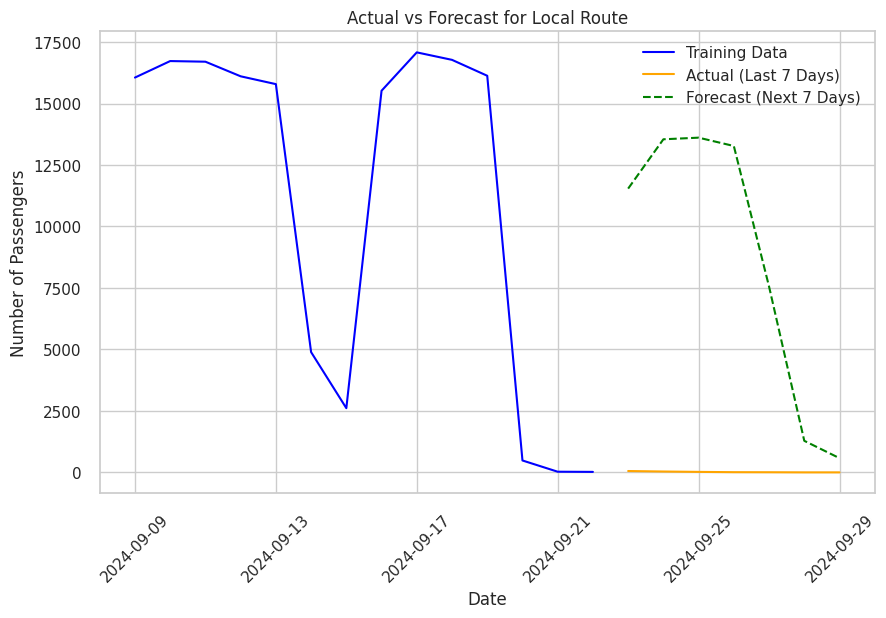


Insight: Forecasting for Local Route
RMSE (Root Mean Square Error): 10240.26
The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. The solid orange line represents the actual data, while the green dashed line shows the forecast. The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.

Forecasted Values for the Next 7 Days:
        Date  Forecasted Passengers
0 2024-09-23           11540.040478
1 2024-09-24           13545.804661
2 2024-09-25           13612.022264
3 2024-09-26           13273.272895
4 2024-09-27            7556.062037
5 2024-09-28            1284.523495
6 2024-09-29             578.982707


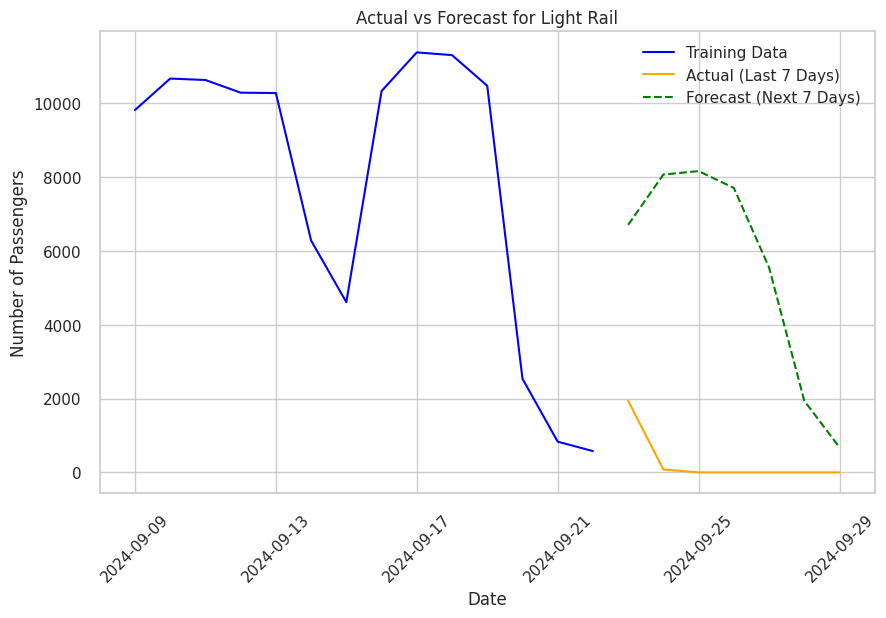


Insight: Forecasting for Light Rail
RMSE (Root Mean Square Error): 5945.19
The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. The solid orange line represents the actual data, while the green dashed line shows the forecast. The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.

Forecasted Values for the Next 7 Days:
        Date  Forecasted Passengers
0 2024-09-23            6703.154595
1 2024-09-24            8064.865570
2 2024-09-25            8158.666719
3 2024-09-26            7703.836746
4 2024-09-27            5549.025495
5 2024-09-28            1938.223213
6 2024-09-29             677.150620


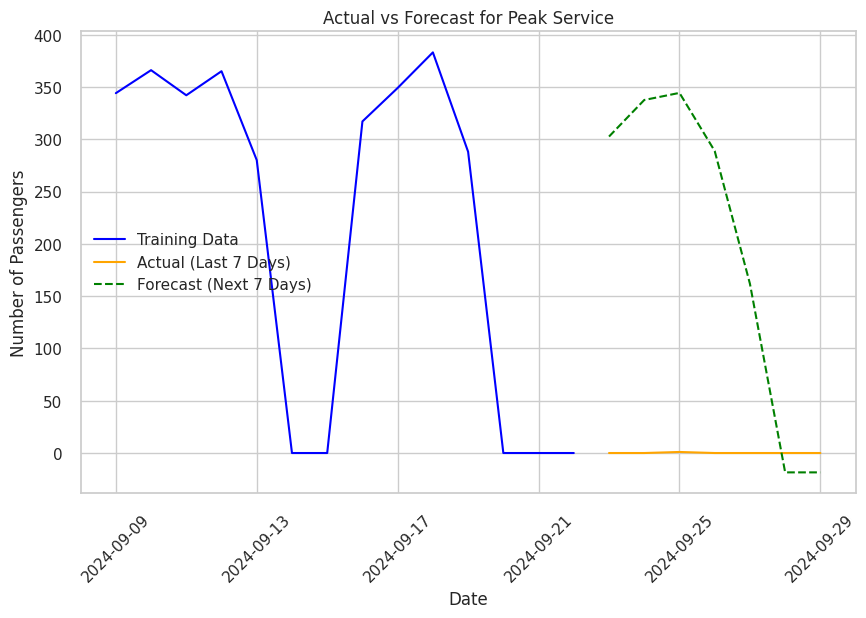


Insight: Forecasting for Peak Service
RMSE (Root Mean Square Error): 248.85
The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. The solid orange line represents the actual data, while the green dashed line shows the forecast. The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.

Forecasted Values for the Next 7 Days:
        Date  Forecasted Passengers
0 2024-09-23             302.527474
1 2024-09-24             337.479122
2 2024-09-25             344.267332
3 2024-09-26             288.726997
4 2024-09-27             161.805253
5 2024-09-28             -18.502701
6 2024-09-29             -18.509026


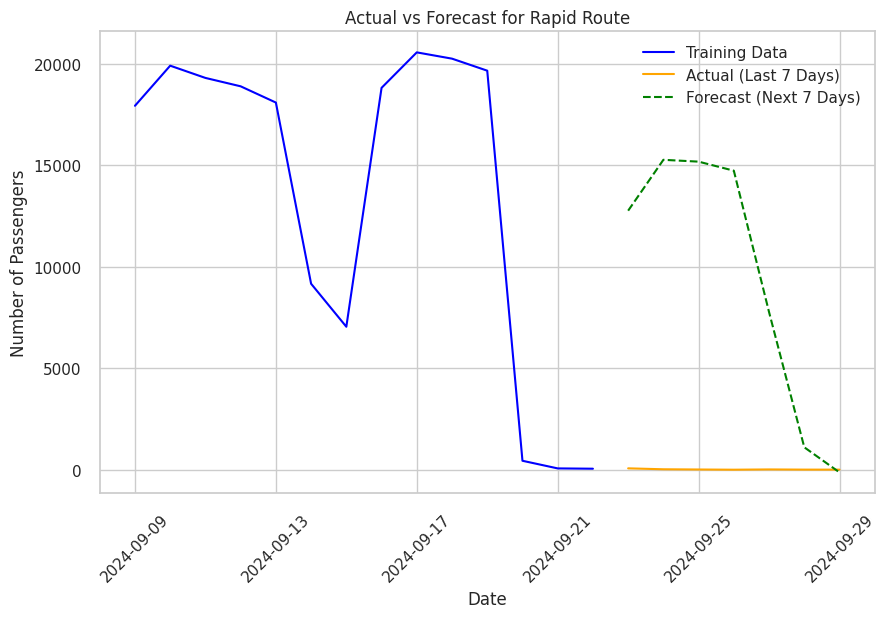


Insight: Forecasting for Rapid Route
RMSE (Root Mean Square Error): 11346.13
The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. The solid orange line represents the actual data, while the green dashed line shows the forecast. The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.

Forecasted Values for the Next 7 Days:
        Date  Forecasted Passengers
0 2024-09-23           12755.446605
1 2024-09-24           15260.489616
2 2024-09-25           15170.443795
3 2024-09-26           14724.488777
4 2024-09-27            7760.622741
5 2024-09-28            1104.086125
6 2024-09-29            -131.788562


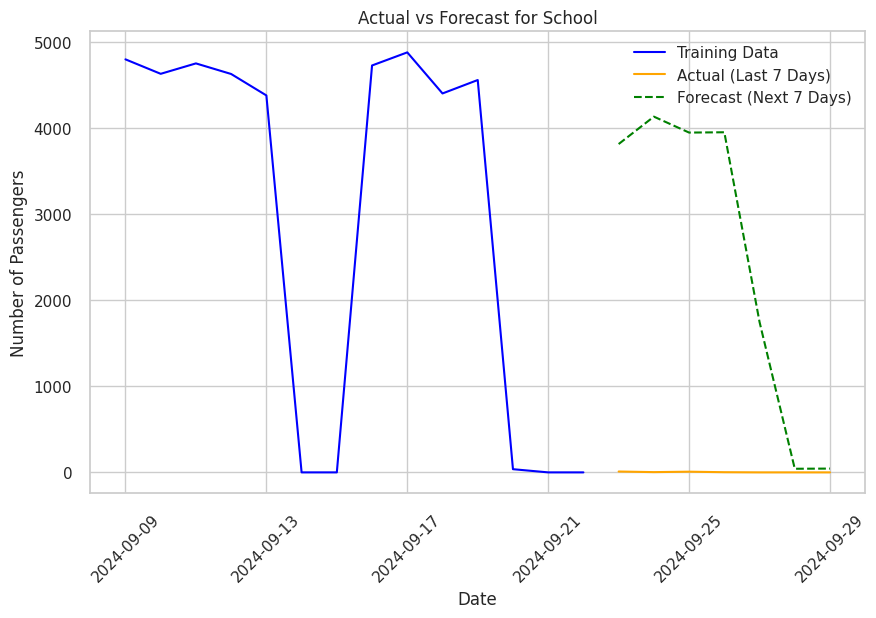


Insight: Forecasting for School
RMSE (Root Mean Square Error): 3062.73
The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. The solid orange line represents the actual data, while the green dashed line shows the forecast. The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.

Forecasted Values for the Next 7 Days:
        Date  Forecasted Passengers
0 2024-09-23            3813.237427
1 2024-09-24            4131.654742
2 2024-09-25            3946.527806
3 2024-09-26            3950.141583
4 2024-09-27            1745.953187
5 2024-09-28              42.057722
6 2024-09-29              44.024399


In [50]:
# Function to forecast, plot, and provide detailed explanations
def forecast_and_plot(data, service_name):
    # Split the data into training (all but last 7 days) and testing (last 7 days)
    train = data[service_name].iloc[:-7]
    test = data[service_name].iloc[-7:]

    # Fit SARIMA model
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)

    # Forecast for the next 7 days
    forecast = model_fit.forecast(steps=7)

    # Calculate Root Mean Square Error (RMSE)
    error = np.sqrt(mean_squared_error(test, forecast))

    # Create a plot comparing actual and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index[-14:], train[-14:], label="Training Data", color="blue")
    plt.plot(test.index, test, label="Actual (Last 7 Days)", color="orange")
    plt.plot(forecast.index, forecast, label="Forecast (Next 7 Days)", linestyle='--', color="green")
    plt.title(f"Actual vs Forecast for {service_name}")
    plt.xlabel("Date")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Detailed Explanation and Forecast Values
    print(f"\nInsight: Forecasting for {service_name}")
    print(f"RMSE (Root Mean Square Error): {error:.2f}")
    print("The graph above compares actual passenger data from the last 7 days with the forecasted values for the next 7 days. "
          "The solid orange line represents the actual data, while the green dashed line shows the forecast. "
          "The goal is to observe how well the forecast aligns with actual patterns. A lower RMSE indicates better performance.")

    print("\nForecasted Values for the Next 7 Days:")
    forecast_df = pd.DataFrame({
        "Date": forecast.index,
        "Forecasted Passengers": forecast.values
    })
    print(forecast_df)

    return forecast

# Apply the function to each service type and visualize results
for service in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']:
    forecast_and_plot(data, service)


